In [2]:
from IPython.display import display, HTML

In [2]:
display(HTML(r"""
<style>
.tutorial-wrap{--bg:#f6f8fc;--panel:#ffffff;--panel-soft:rgba(255,255,255,.75);--stroke:rgba(16,24,40,.12);--text:#0f172a;--muted:rgba(15,23,42,.7);--accent:#2563eb;--radius:18px;font-family:system-ui,-apple-system,sans-serif;color:var(--text);padding:22px;margin:8px 0 18px;background:radial-gradient(1000px 500px at 15% 10%,rgba(37,99,235,.15),transparent 55%),radial-gradient(800px 450px at 85% 15%,rgba(124,58,237,.12),transparent 50%),var(--bg)}
.hero-section{display:grid;grid-template-columns:1.2fr .8fr;gap:18px;align-items:center;padding:18px;border-radius:calc(var(--radius) - 6px);background:linear-gradient(135deg,var(--panel),var(--panel-soft))}
.content-grid{margin-top:16px}
.tutorial-title{margin:0;font-size:clamp(2.1rem,5vw,3rem);line-height:1.1}
.tutorial-subtitle{margin:10px 0 0;color:var(--muted);font-size:1.0rem;max-width:70ch}
.tutorial-card{background:var(--panel);padding:16px 18px}
.tutorial-card h2{margin:0 0 10px;font-size:1.3rem}
.tutorial-card p{margin:0 0 10px;color:var(--muted);font-size:1.0rem;line-height:1.55;text-align:justify}
.tutorial-wrap a{color:var(--accent);text-decoration:none;border-bottom:1px dashed rgba(37,99,235,.5)}
.tutorial-wrap a:hover{border-bottom-style:solid}
.tutorial-wrap code{font-family:ui-monospace,monospace;background:#f1f5f9;border-radius:8px;padding:2px 6px}
.logo-box{display:flex;justify-content:center}
.logo-box img{width:min(260px,100%);height:auto;filter:drop-shadow(0 10px 22px rgba(0,0,0,.22))}
@media (max-width:980px){.hero-section{grid-template-columns:1fr}.logo-box{justify-content:flex-start}}
</style>

<div class="tutorial-wrap" id="tutorialIntro">
  <div class="hero-section">
    <div>
      <h1 class="tutorial-title">SPARC Tutorial</h1>
      <p class="tutorial-subtitle">
        A hands-on of <b>SPARC</b> (Smart Potential with Atomistic Rare Events and Continuous Learning):
        an automated workflow for constructing machine learning interatomic potentials (MLIPs).
      </p>
    </div>
    <div class="logo-box">
      <img src="https://raw.githubusercontent.com/rahulumrao/sparc/main/docs/_static/sparc_logo.png" alt="SPARC logo"/>
    </div>
  </div>
  <div class="content-grid">
    <div class="tutorial-card">
      <h2>Introduction</h2>
      <p>SPARC is a Python package built around the <code>ASE</code> interface and provides a modular workflow for training machine learning interatomic potentials (MLIPs) for reactive and nonreactive systems.</p>
      <p>This notebook provides a tutorial for executing the SPARC active learning workflow.</p>
      <p>References and project materials:
        <a href="https://docs-sparc.readthedocs.io/en/latest/" target="_blank">SPARC documentation</a> ·
        <a href="https://github.com/rahulumrao/sparc" target="_blank">GitHub repository</a>
      </p>
    </div>
  </div>
</div>
"""))

#### [1] **Setup and Installation**

<!-- !pip install git+https://github.com/rahulumrao/sparc.git -->

Create and Initialize `conda` environment

In [3]:
# Optional: Only required when running in Google Colab.
# If you are running this notebook locally, you can skip this cell.

def in_colab():
    try:
        import google.colab  # noqa
        return True
    except ImportError:
        return False


if in_colab():
    try:
        import condacolab
        print(" Colab environment detected - condacolab already installed.")
    except ImportError:
        print(" Google Colab environemnt detected ==> installing condacolab...")
        !pip install -q condacolab
        import condacolab
        condacolab.install()
else:
    print("Running Locally ==> skipping Colab setup.\n")
    print("\033[90mCreate a conda environment if needed:\033[0m")
    print("\033[94m  conda create -n sparc python=3.10\033[0m")
    print("\033[94m  conda activate sparc\033[0m\n")

Running Locally ==> skipping Colab setup.

Create a conda environment if needed:
  conda create -n sparc python=3.10
  conda activate sparc



In this tutorial, we will use [CP2K](https://anaconda.org/conda-forge/cp2k) for first-principles labeling.

In [23]:
%%capture
! conda install conda-forge::cp2k

The conda CP2K distribution does not include `cp2k_shell.x` (required by ASE), so we create a symbolic link as a workaround.

In [25]:
!path=$(which cp2k.ssmp) && ln -sf "$path" "$(dirname "$path")/cp2k_shell.ssmp"

In [26]:
!which cp2k_shell.ssmp

/home/wazel/anaconda3/envs/notebook/bin/cp2k_shell.ssmp


Install [SPARC](https://github.com/rahulumrao/sparc) and its dependencies ([DeePMD-kit](https://github.com/deepmodeling/deepmd-kit) and [PLUMED](https://www.plumed.org/))

In [ ]:
%%capture
!pip install git+https://github.com/rahulumrao/sparc.git
!pip install deepmd-kit[gpu,cu12]==2.2.10
!conda install -c conda-forge py-plumed

In [28]:
# to avoid a known runtime issue. Not required for local runs.
import os

try:
    import google.colab  # noqa
    os.environ["MPLBACKEND"] = "Agg"
except ImportError:
    pass

After installation, verify that SPARC is correctly installed. You should see output similar to the following:

<span style="font-size: 0.8em;">
<!-- After installation, verify that SPARC is correctly installed. You should see output similar to the following: -->
<span style="font-size: 0.8em;">

```text
[SPARC][INFO] 
         ######  ########     ###    ########   ######
        ##    ## ##     ##   ## ##   ##     ## ##    ##
        ##       ##     ##  ##   ##  ##     ## ##
         ######  ########  ##     ## ########  ##
              ## ##        ######### ##   ##   ##
        ##    ## ##        ##     ## ##    ##  ##    ##
         ######  ##        ##     ## ##     ##  ######
         --v0.1.0

usage: sparc [-h] [-i INPUT_FILE]

Run main SPARC workflow

options:
  -h, --help            show this help message and exit
  -i INPUT_FILE, --input_file INPUT_FILE
                        Input YAML file

In [44]:
# Suppress TensorFlow / DeepMD warnings
import os, logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger().setLevel(logging.ERROR)

In [45]:
!sparc -h

Instructions for updating:
non-resource variables are not supported in the long term
[SPARC][INFO] 
         ######  ########     ###    ########   ######
        ##    ## ##     ##   ## ##   ##     ## ##    ##
        ##       ##     ##  ##   ##  ##     ## ##
         ######  ########  ##     ## ########  ##
              ## ##        ######### ##   ##   ##
        ##    ## ##        ##     ## ##    ##  ##    ##
         ######  ##        ##     ## ##     ##  ######
         --v0.1.0
usage: sparc [-h] [-i INPUT_FILE]

Run main SPARC workflow

options:
  -h, --help            show this help message and exit
  -i INPUT_FILE, --input_file INPUT_FILE
                        Input YAML file


#### [2] Download the training data and input files

In [4]:
import gdown

file_id = "1mHhjhwJ8s2ttE1MuZHeOTGpA1N3JPML8"
gdown.download(f"https://drive.google.com/uc?id={file_id}", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1mHhjhwJ8s2ttE1MuZHeOTGpA1N3JPML8
To: /home/wazel/rahul/sparc/nh3bh3/Notebook/NoteBookData.zip
100%|██████████| 20.2k/20.2k [00:00<00:00, 65.3MB/s]


'NoteBookData.zip'

In [5]:
!unzip NoteBookData.zip 

Archive:  NoteBookData.zip
   creating: NoteBookData/
  inflating: NoteBookData/input.json  
  inflating: NoteBookData/input.yaml  
  inflating: NoteBookData/README.md  
  inflating: NoteBookData/cp2k_template.inp  
  inflating: NoteBookData/plumed_dp.dat  
  inflating: NoteBookData/AmmoniaBorate.xyz  
   creating: NoteBookData/iter_000000/
   creating: NoteBookData/iter_000000/00.dft/
  inflating: NoteBookData/iter_000000/00.dft/AseMD.traj  


In [9]:
%cd NoteBookData

/home/wazel/rahul/sparc/nh3bh3/Notebook/NoteBookData


In [7]:
!ls

AmmoniaBorate.xyz  input.json  iter_000000    README.md
cp2k_template.inp  input.yaml  plumed_dp.dat


**Dataset contents**

The downloaded archive contains the following files:

- **AmmoniaBorate.xyz** — Initial atomic structure in XYZ format used to start the simulation.
- **cp2k_template.inp** — Template CP2K input file for first-principles labeling.
- **input.yaml** — Main SPARC configuration file defining the workflow and parameters.
- **input.json** — DeePMD training configuration file.
- **plumed_dp.dat** — PLUMED input file to accelerate ML/MD exploration.
- **iter_000000/** — Initial iteration directory containing seed data.

#### [3] Configure the CP2K data directory

CP2K requires access to basis sets and pseudopotentials via the `CP2K_DATA_DIR` environment variable.  
To ensure portability across local, Colab, and conda environments, we automatically detect the CP2K installation path and set the data directory accordingly.

In [8]:
import os
import subprocess
from pathlib import Path

cp2k_path = subprocess.check_output(["which", "cp2k.ssmp"], text=True).strip()
cp2k_root = Path(cp2k_path).resolve().parent.parent
data_dir = cp2k_root / "share" / "cp2k" / "data"

os.environ["CP2K_DATA_DIR"] = str(data_dir)

print("CP2K_DATA_DIR =", os.environ["CP2K_DATA_DIR"])

CP2K_DATA_DIR = /home/wazel/anaconda3/envs/notebook/share/cp2k/data


The CP2K executable may be installed in different locations depending on the system. We therefore need to update the `exe_command` entry in `input.yaml` with the correct path.

In [9]:
!p=$(which cp2k_shell.ssmp); sed -i "s|^[[:space:]]*exe_command:.*|  exe_command: \"env OMP_NUM_THREADS=4 $p\"|" input.yaml

In [10]:
cp2k_path

'/home/wazel/anaconda3/envs/notebook/bin/cp2k.ssmp'

#### [4] Run SPARC active learning workflow

In [11]:
# Run workflow
!sparc -i input.yaml

2026-02-20 14:19:22.695336: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-20 14:19:22.732151: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-20 14:19:23.230709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Instructions for updating:
non-resource variables are not supported in the long term
[SPARC][INFO] 
         ######  ########     ###    ########   ######
        ##    ## ##     ##   ## ## 

#### [5] Utility functions to monitor workflow

There are some utility functions within the `plot_utils` module for monitoring and postprocessing the AL workflow

In [2]:
import inspect
import sparc.src.utils.plot_utils as mymodule

functions = inspect.getmembers(mymodule, inspect.isfunction)
for name, func in functions:
    print(name)


ParityPlot
PlotDistribution
PlotForceDeviation
PlotLcurve
PlotPES
PlotPotentialEnergy
PlotTemp
ReadColvar
ViewTraj
compute_mae
compute_rmse
get_1dSurface
get_2dSurface
read


In [89]:
# Utility function to plot the temperature profile during the DP/MD simulation to see if dynamics is stable.
from sparc.src.utils.plot_utils import PlotTemp

In [90]:
# We can learn about the function signature and usage with the built-in help function.
help(PlotTemp)

Help on function PlotTemp in module sparc.src.utils.plot_utils:

PlotTemp(root_dir='.', iteration_window='all', target_iteration=None, traj_filename='dpmd.traj')
    Parses trajectory files from iter_* directories (or a specific range/iteration/all),
    extracts temperature, and plots the results.
    
    Parameters:
        root_dir (str): Root directory containing iter_* folders.
        iteration_window (tuple or str): A tuple (start, end) to specify a range of iterations, or "all" to process all iterations.
        target_iteration (int): A specific iteration number to analyze.
        traj_filename (str): Name of the trajectory file to read in each iteration folder.
    
    Example:
        >>> plot_temperature("/path/to/root", iteration_window=(2, 5), traj_filename="dpmd.traj")
        >>> plot_temperature("/path/to/root", target_iteration=3, traj_filename="dpmd.traj")
        >>> plot_temperature("/path/to/root", iteration_window="all", traj_filename="dpmd.traj")



Mean Temperature (K) from Iteration 0 := 333.33


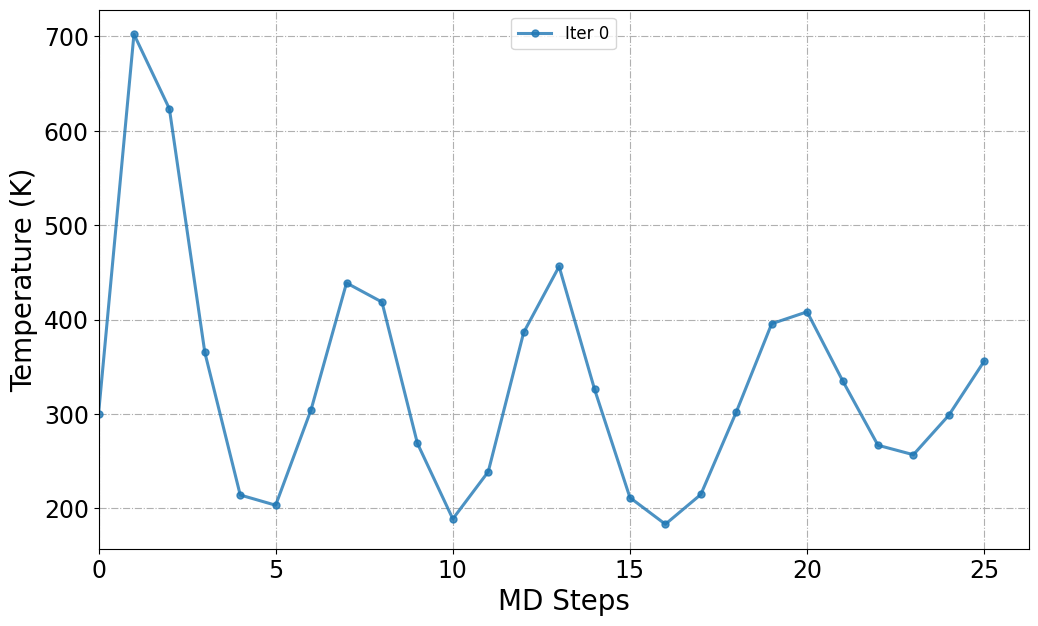

In [12]:
PlotTemp(root_dir='.', iteration_window='all')

In [13]:
from sparc.src.utils.plot_utils import PlotForceDeviation

This function plots the atomic force deviations during the ML/MD simulation 
These error in forces are calculated by the defintion [here](https://docs.deepmodeling.com/projects/deepmd/en/master/test/model-deviation.html). 

The shaded region defined within `dmin` and `dmax` are the **max**/**min** cutoff forces and candidates within this shaded region are selected for DFT-labelling. Each marker point corresponds to a single candidate.

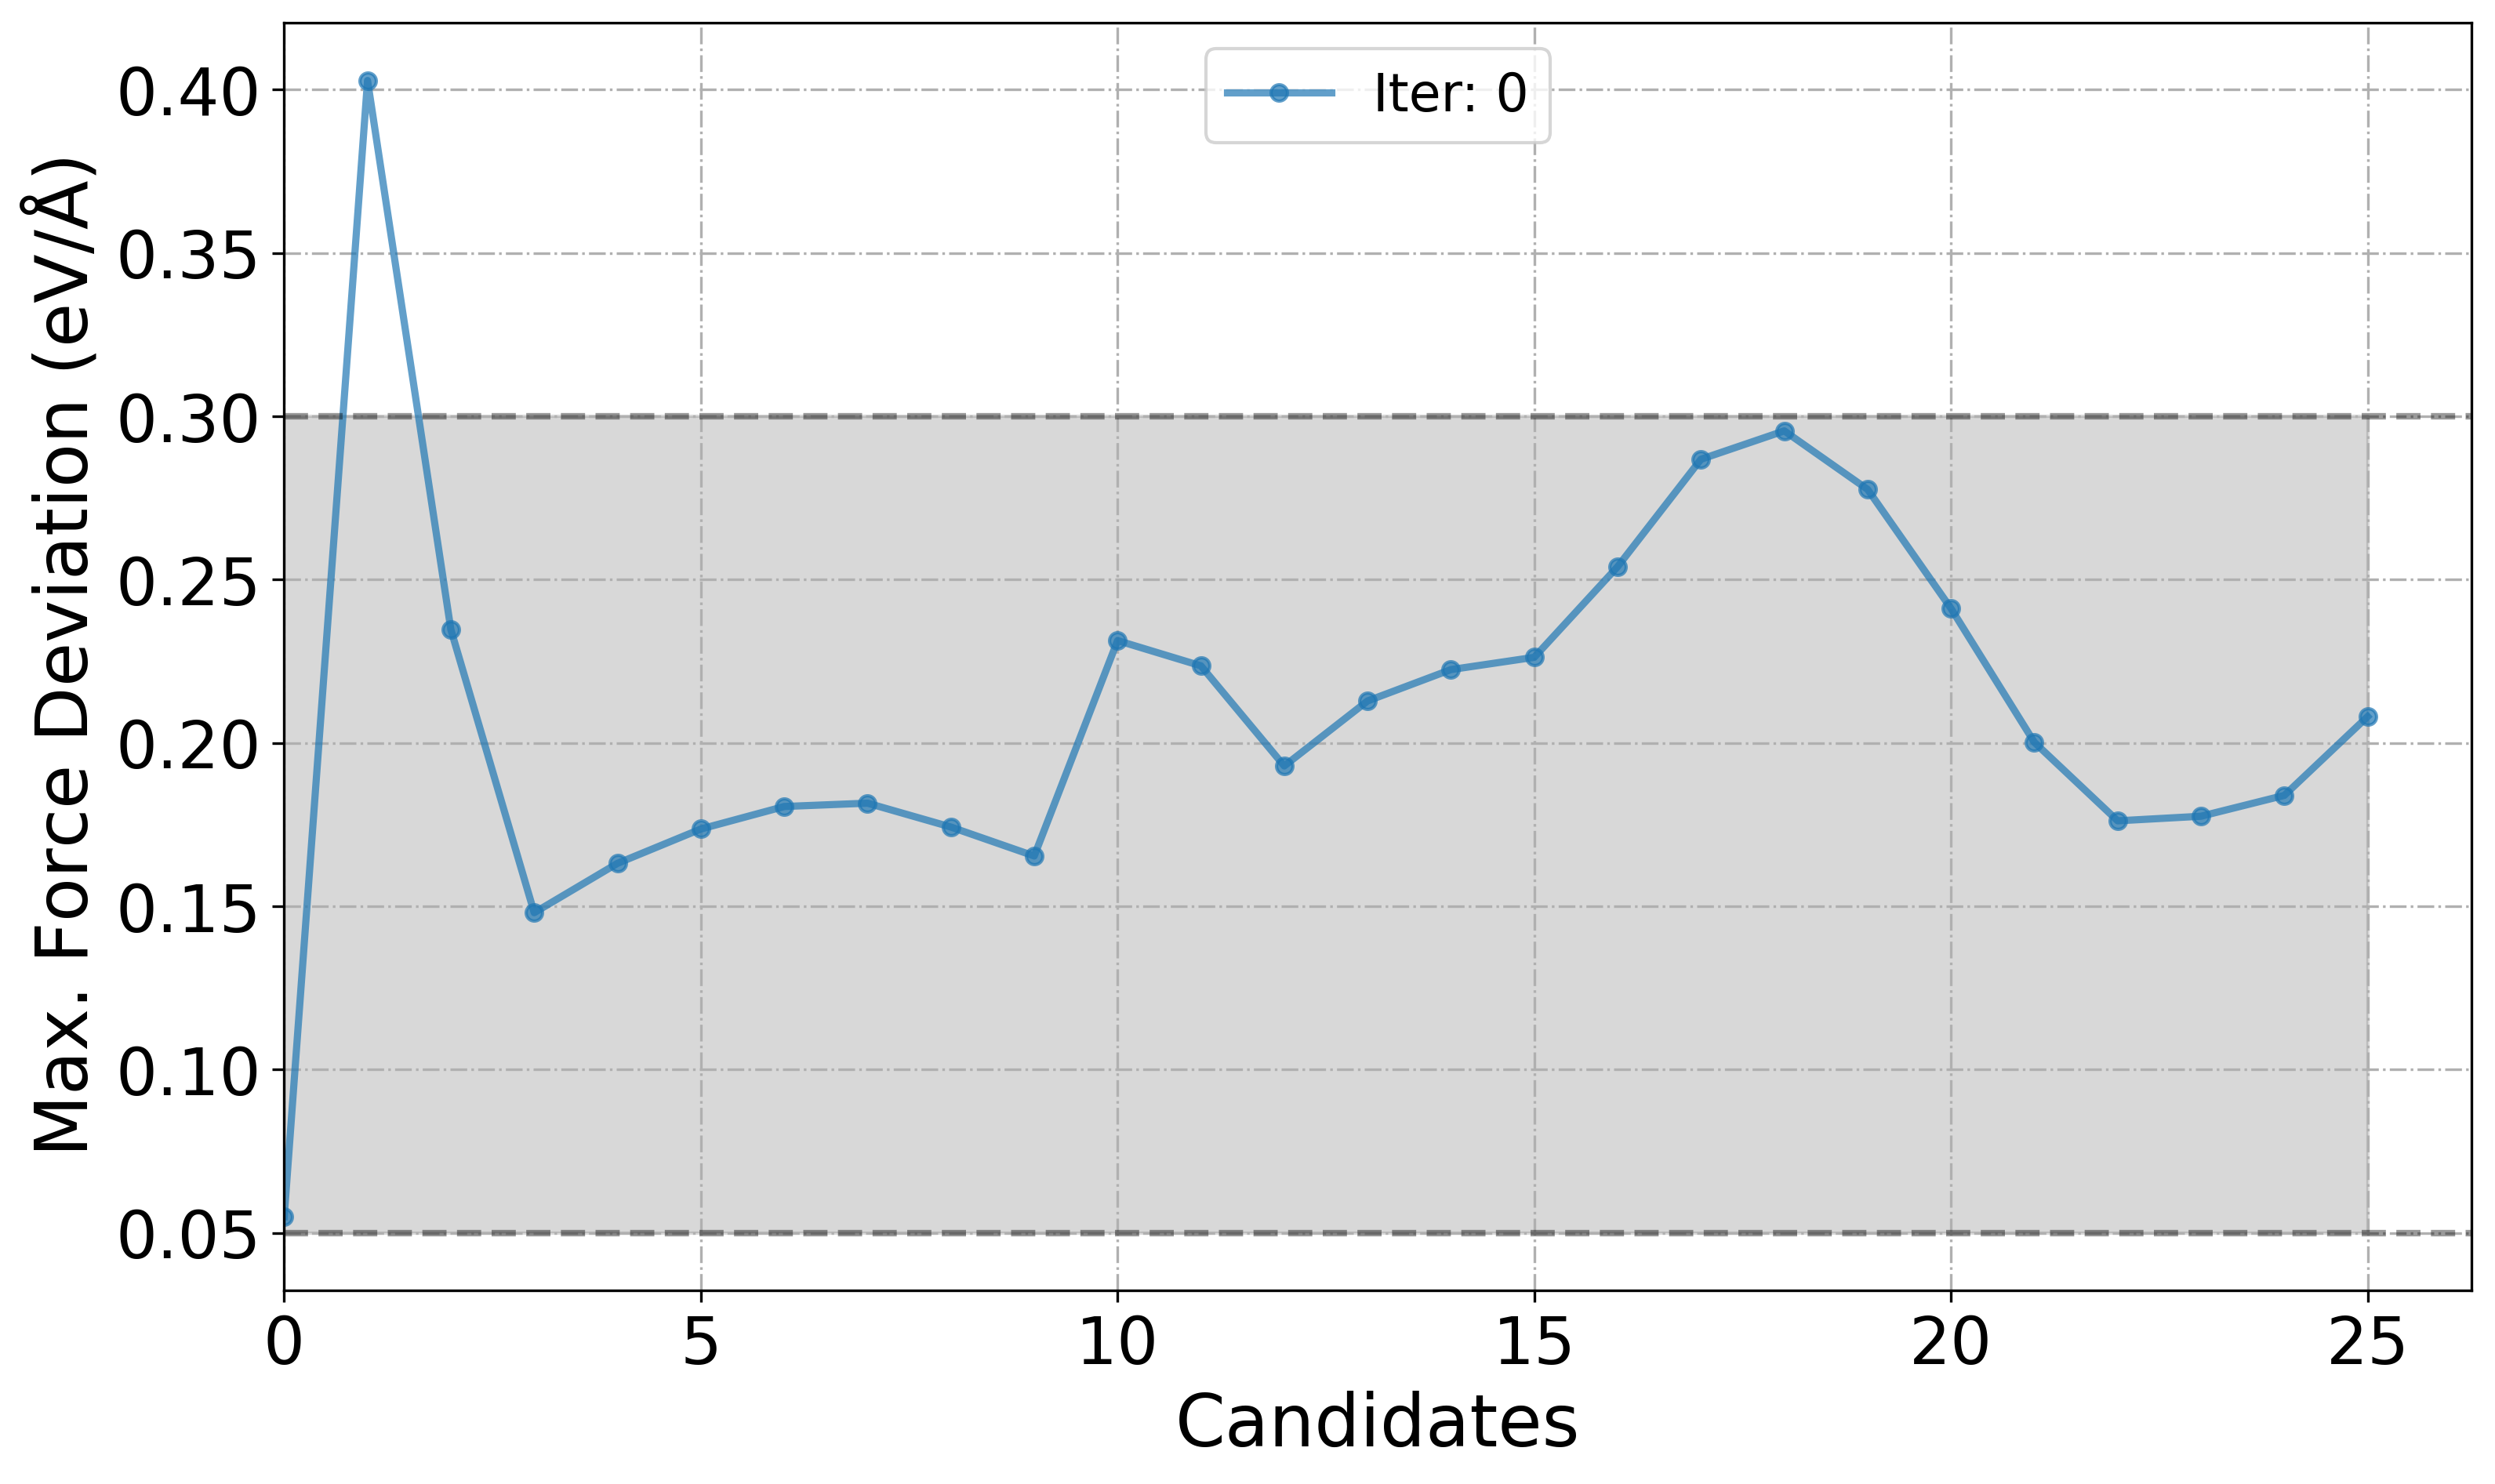

In [ ]:
PlotForceDeviation(root_dir='.', iteration_window='all', dmin=0.05, dmax=0.3)

In [24]:
from sparc.src.utils.plot_utils import PlotDistribution

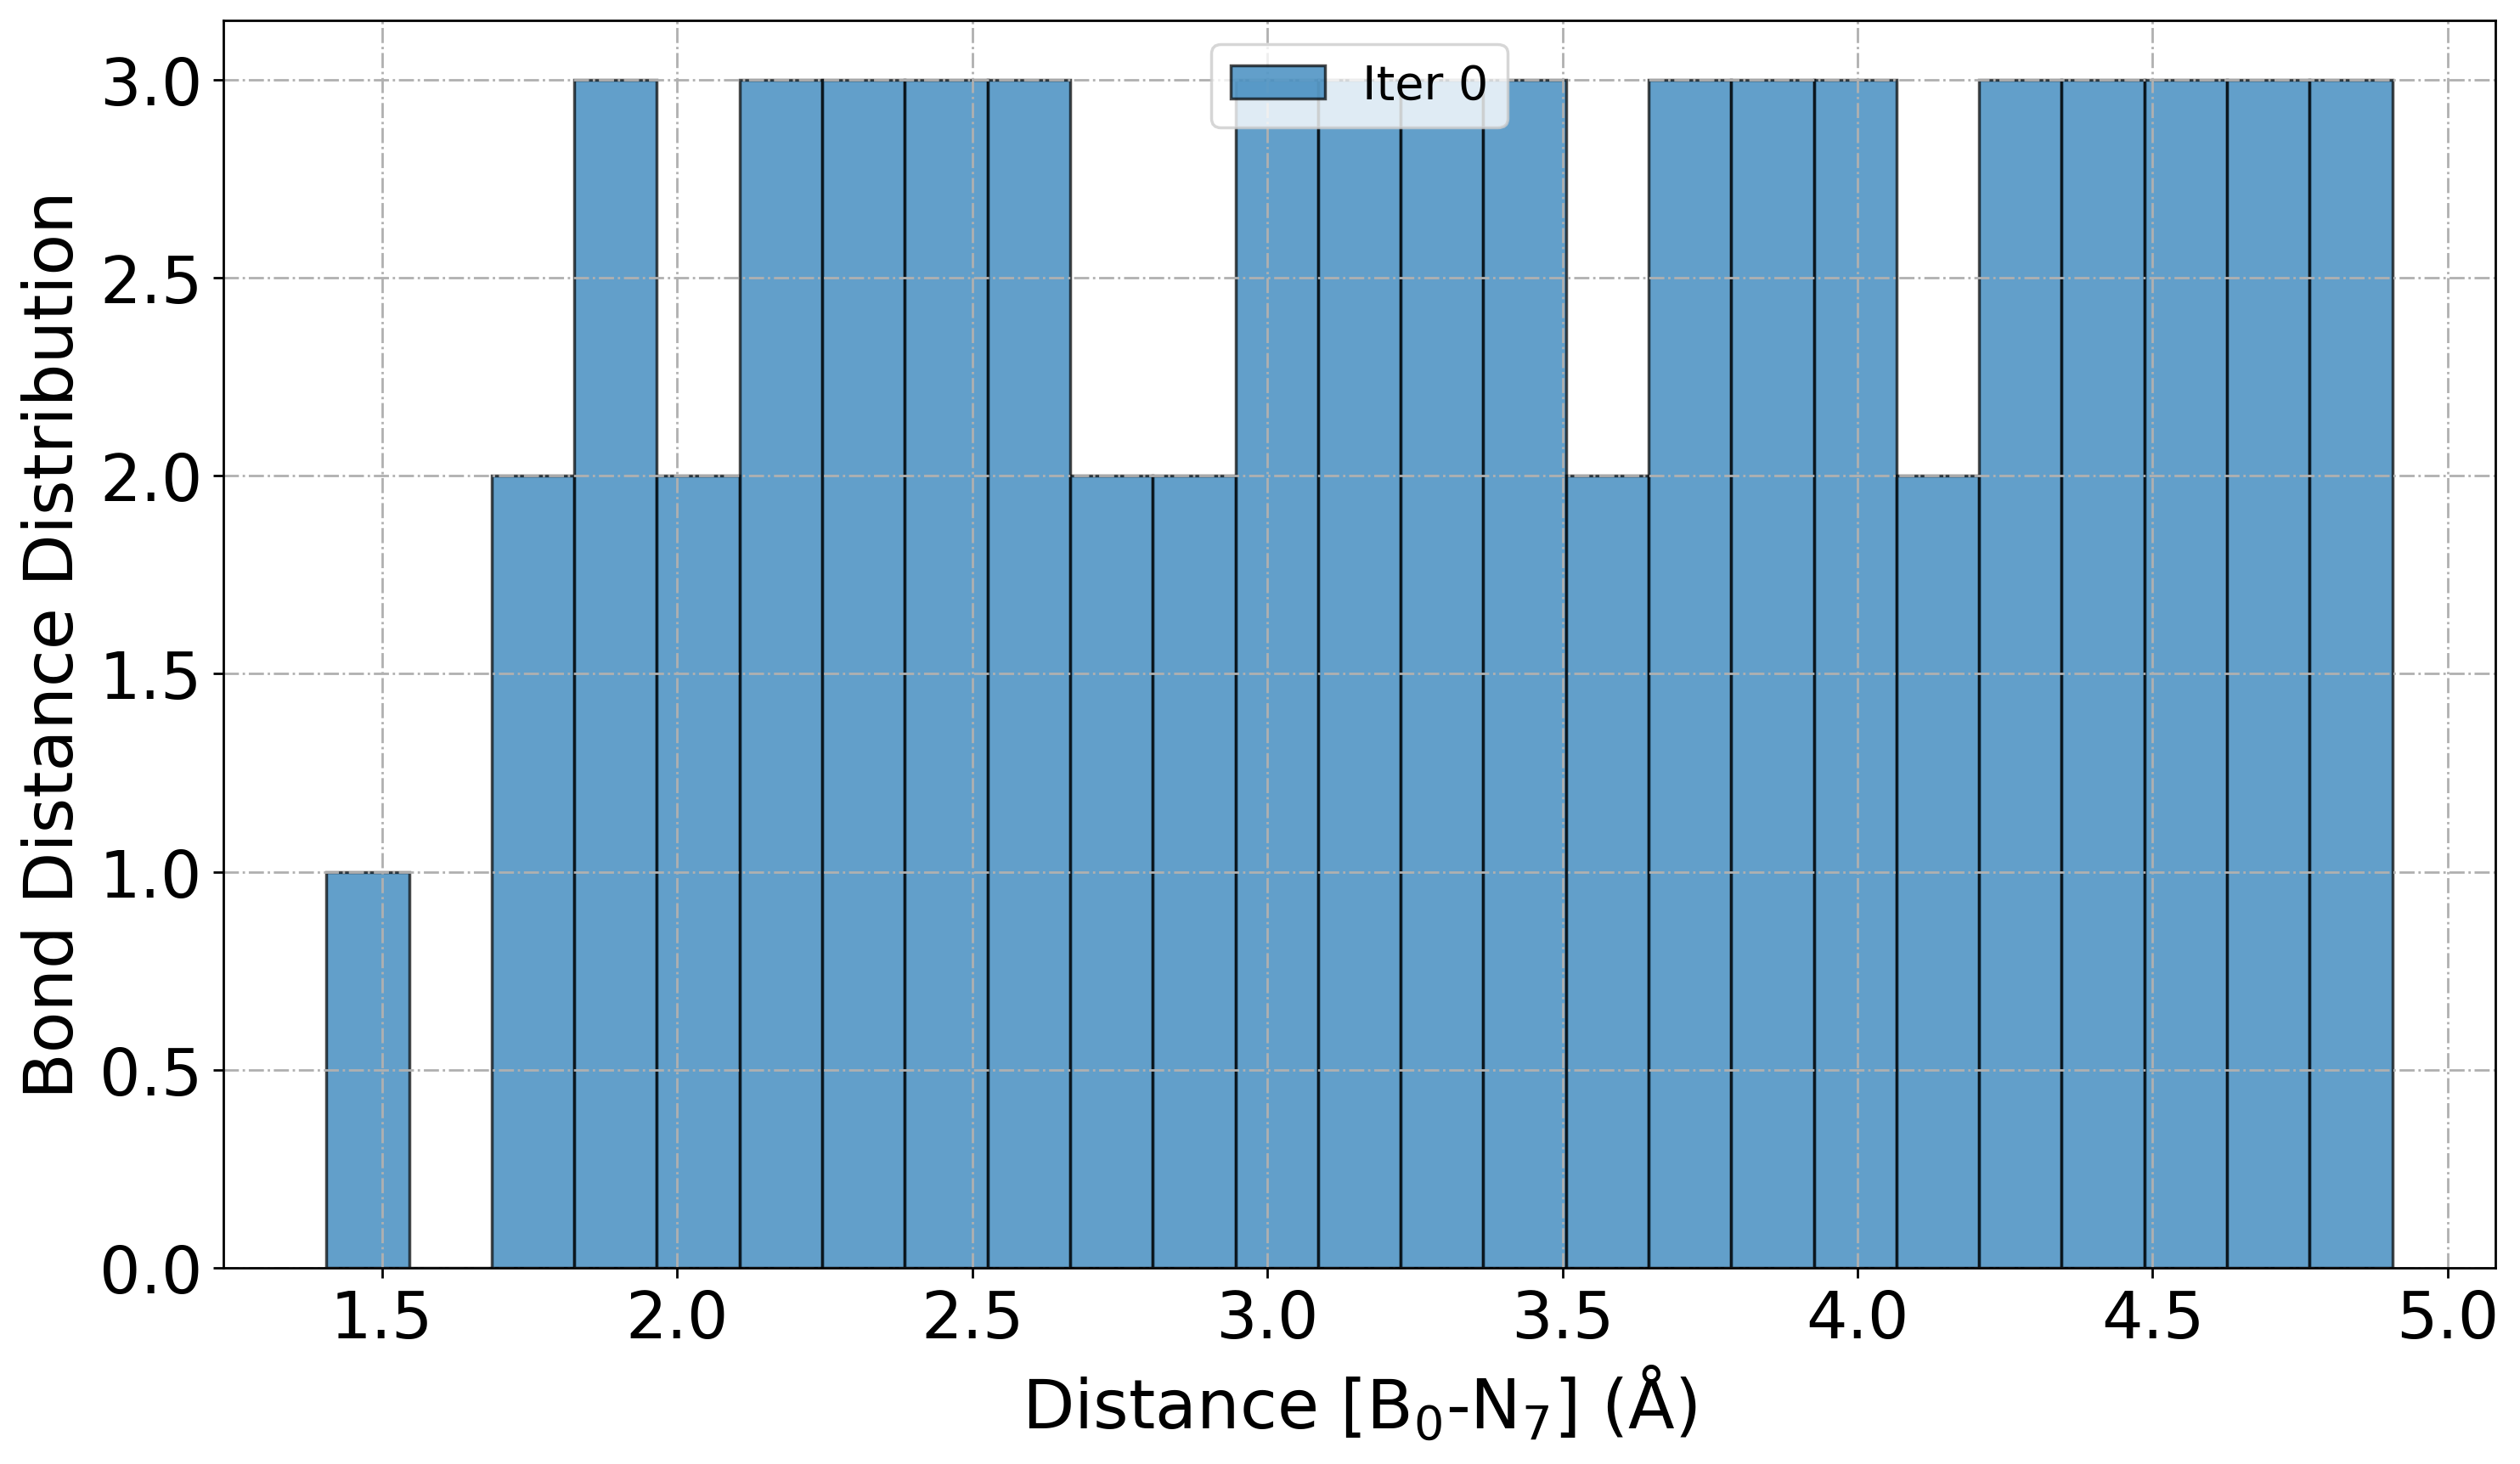

In [92]:
# We can also check how data is distributed along any coordinate to check the quality of sampling.
PlotDistribution(root_dir='.', iteration_window='all', type='hist', get='distance:0,7', bins=25)

In [45]:
from sparc.src.utils.plot_utils import PlotLcurve, ParityPlot

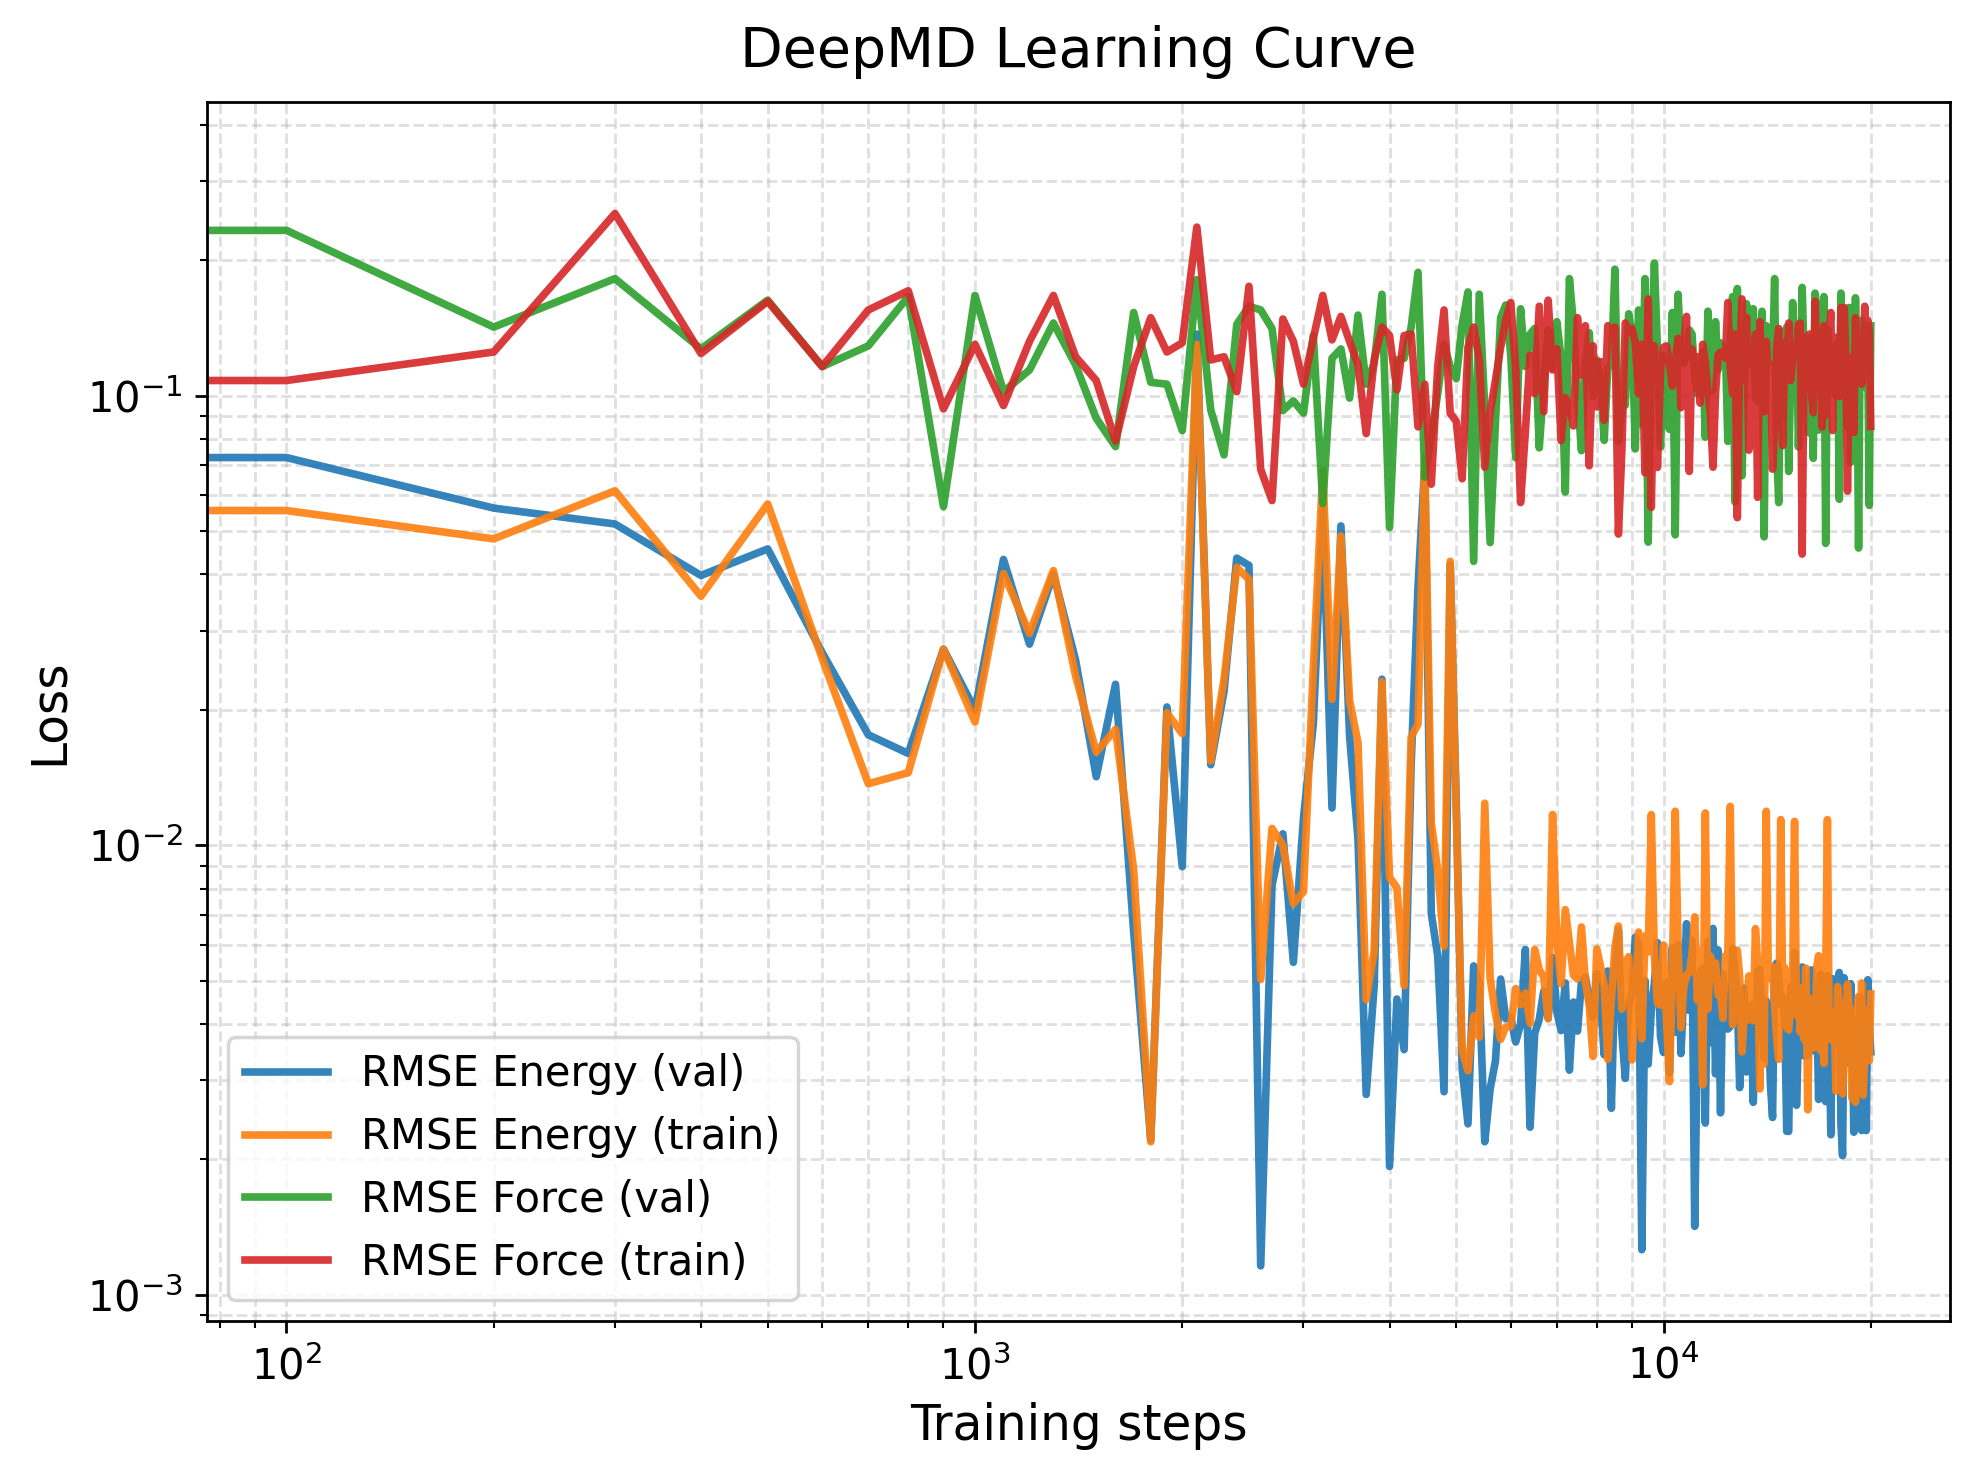

In [ ]:
# plot the learning curve to monitor training progress and check for convergence
PlotLcurve(lcurve_file='iter_000000/01.train/training_1/lcurve.out')

2026-02-25 11:11:17.611621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22212 MB memory:  -> device: 0, name: NVIDIA RTX 4500 Ada Generation, pci bus id: 0000:55:00.0, compute capability: 8.9
2026-02-25 11:11:17.612941: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22353 MB memory:  -> device: 1, name: NVIDIA RTX 4500 Ada Generation, pci bus id: 0000:a2:00.0, compute capability: 8.9


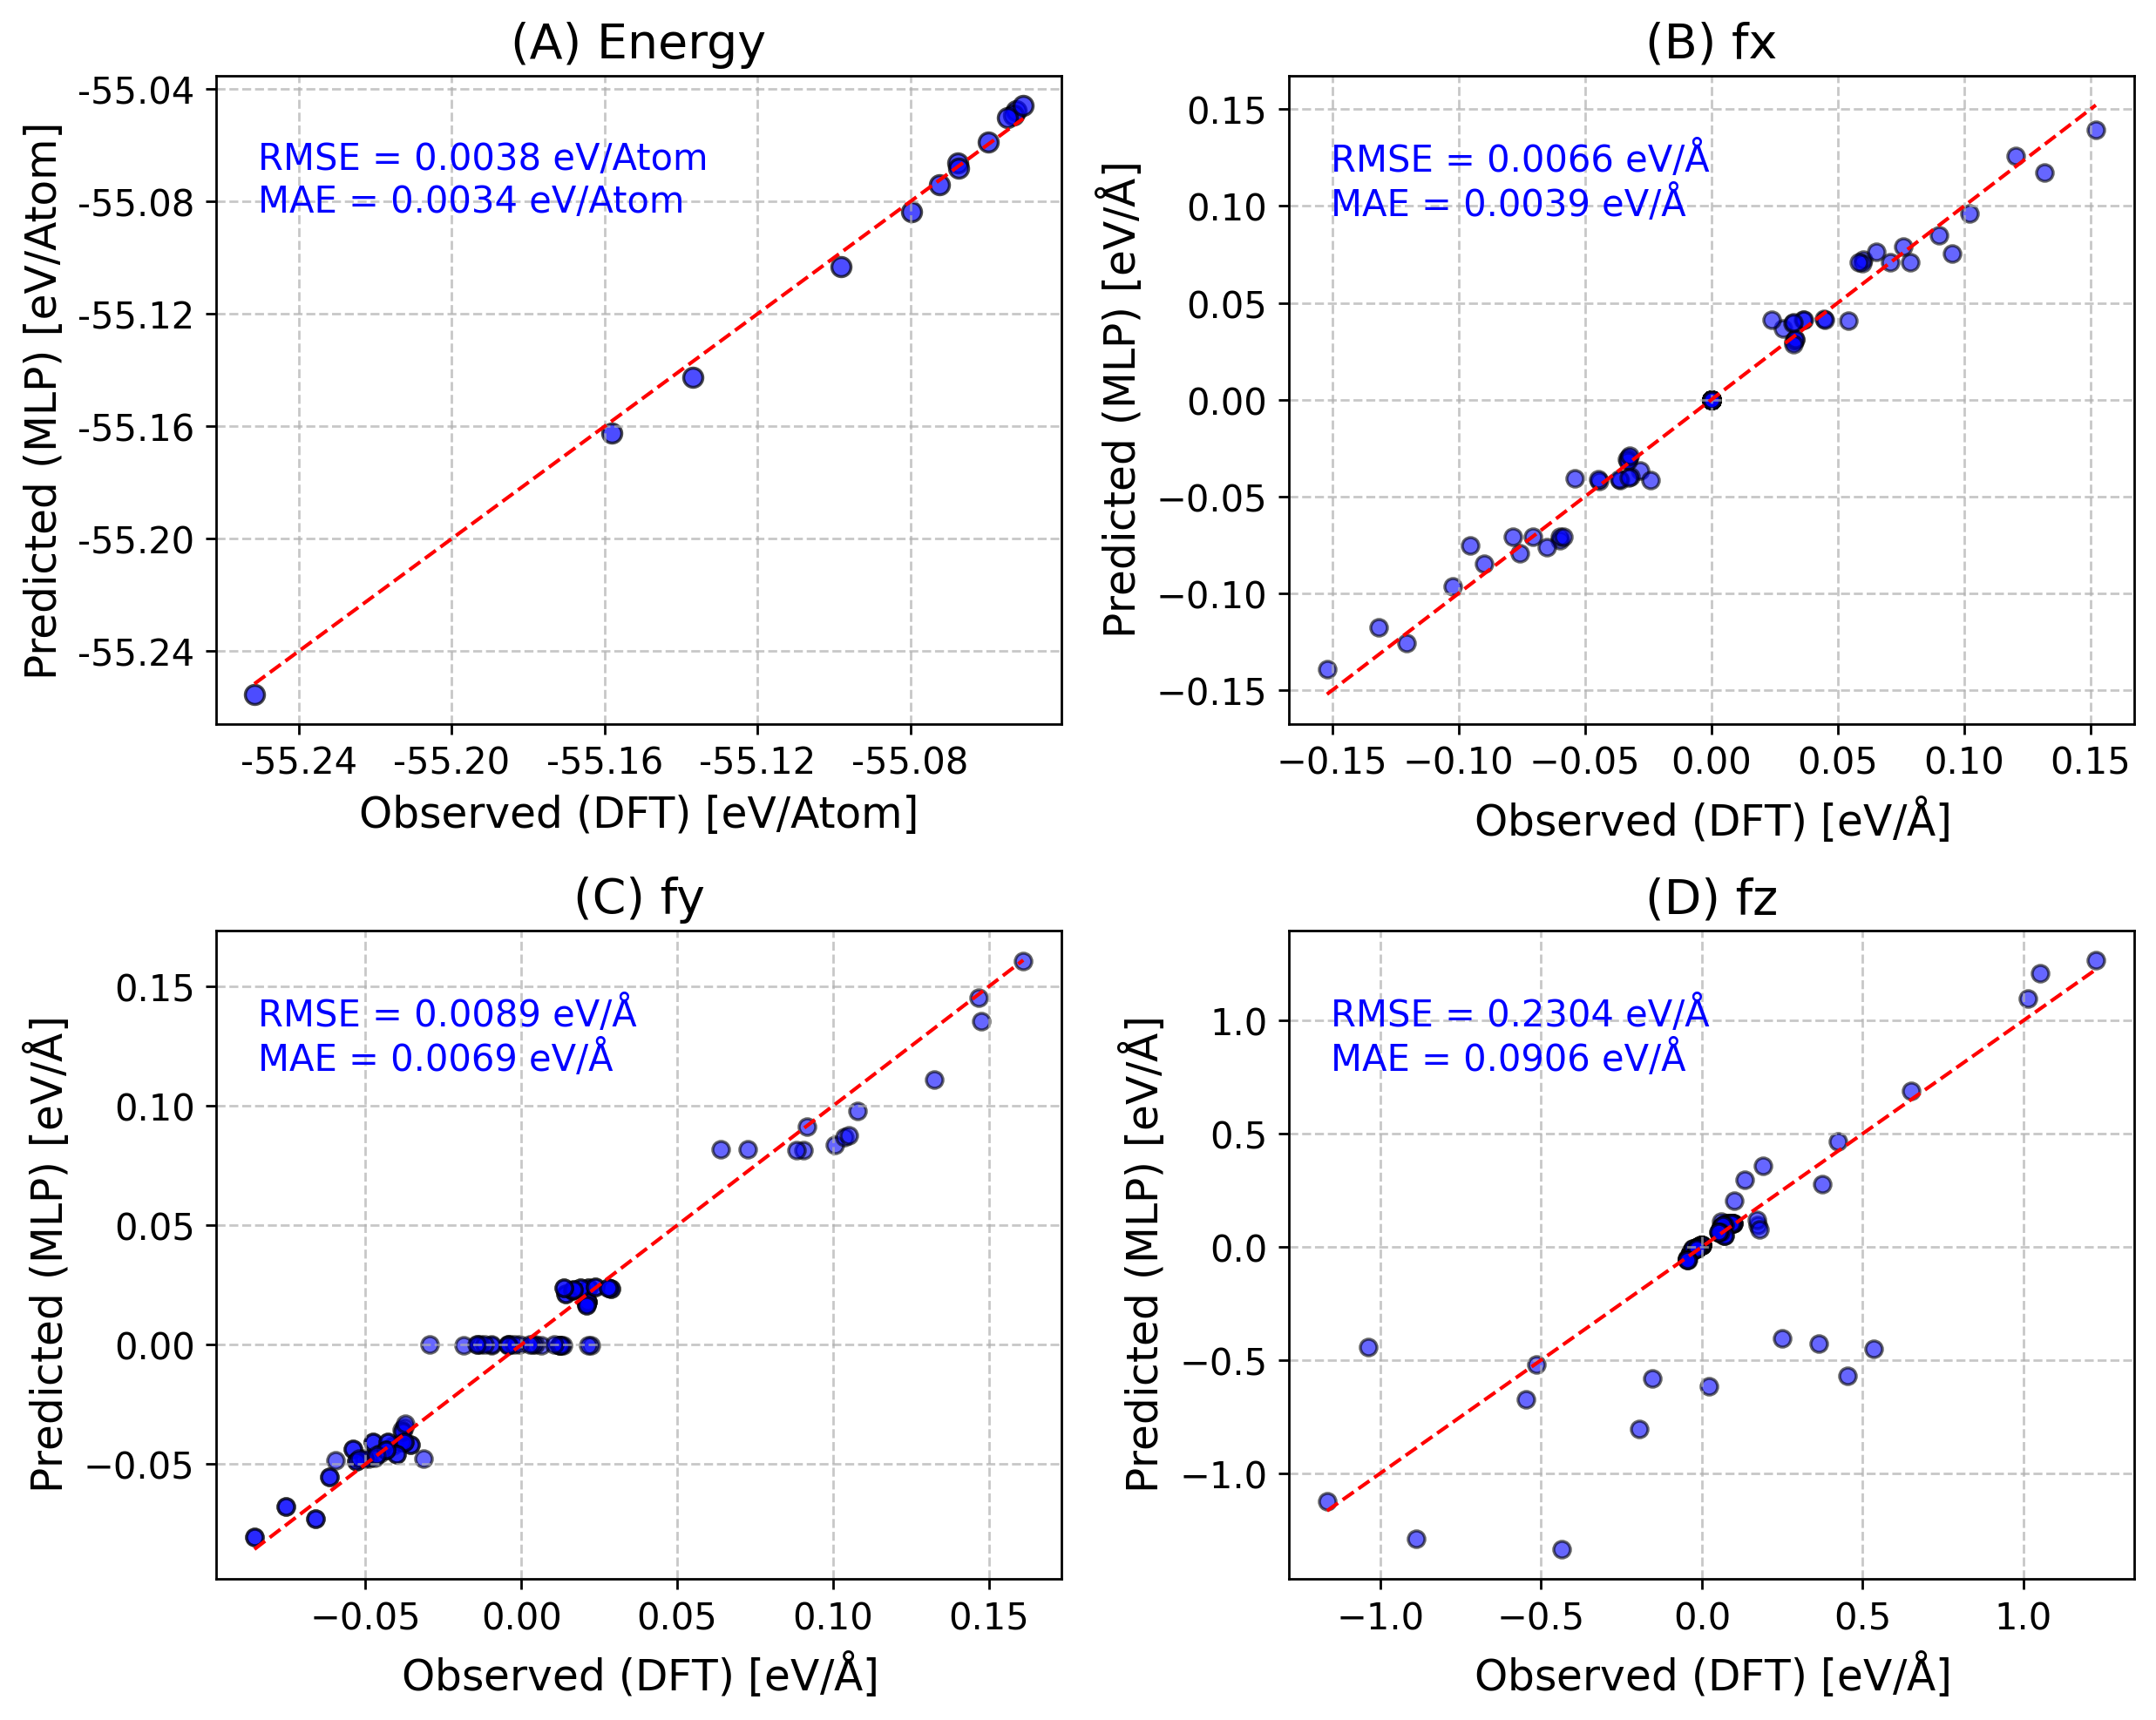

In [ ]:
# We can plot forces, and energies as parity plots.
# PlotParity(data_dir='DeePMD_training/00.data/validation_data', model_path="iter_000000/01.train/training_1/frozen_model_1.pb", per_atom=True, type="energy")
ParityPlot(data_dir='DeePMD_training/00.data/validation_data', 
           model_path="iter_000000/01.train/training_1/frozen_model_1.pb", 
           per_atom=True, 
           type="all")

In [86]:
# We can also read the COLVAR file generated during the DP/MD simulation
from sparc.src.utils.plot_utils import ReadColvar

In [64]:
df = ReadColvar(file_path='iter_000000/02.dpmd/COLVAR')
df.head()

,time,d1,uwall.bias,uwall.force2,rest.bias,rest.force2,rest.d1_cntr,rest.d1_work,rest.d1_kappa,rest.work
0,0.000,0.140600,0.0,0.0,0.001800,35.995920,0.1400,0.000000,10000.0,0.000000
1,0.005,0.140760,0.0,0.0,0.000130,2.618758,0.1406,-0.002158,10100.0,-0.002158
2,0.010,0.141177,0.0,0.0,0.000003,0.053440,0.1412,-0.002451,10200.0,-0.002451
3,0.015,0.141848,0.0,0.0,0.000012,0.244788,0.1418,-0.002406,10300.0,-0.002406
4,0.020,0.142766,0.0,0.0,0.000697,14.497711,0.1424,-0.003570,10400.0,-0.003570


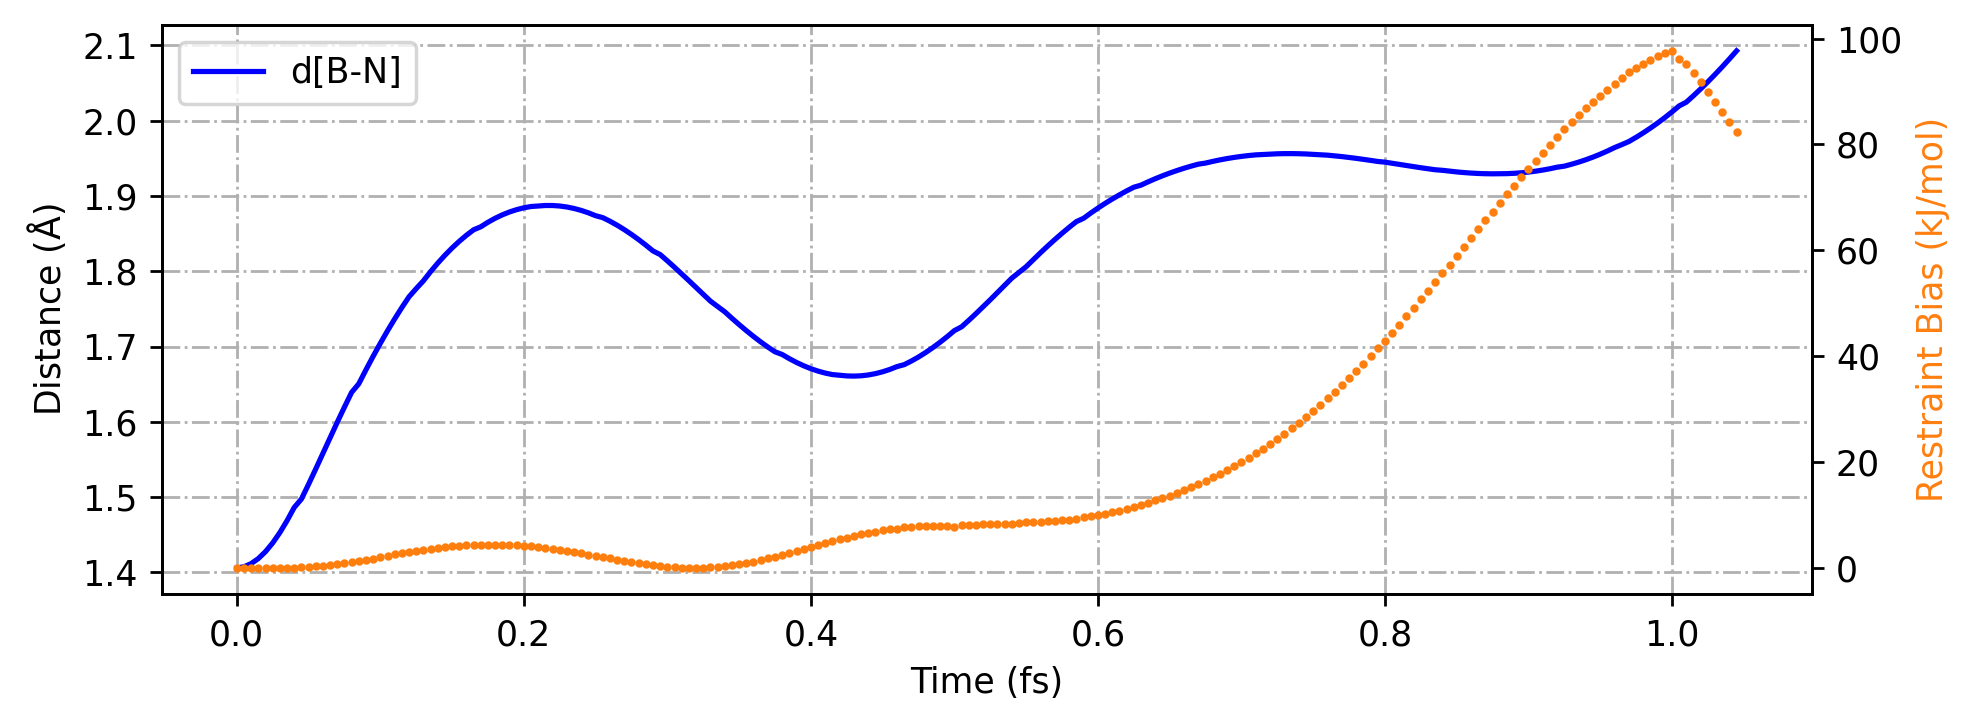

In [85]:
fig, ax = plt.subplots(figsize=(8, 3), dpi=250)

ax.plot(df['time'], df['d1']*10, label='d[B-N]', c='blue')

ax1 = ax.twinx()
ax1.scatter(df['time'], df['rest.bias'], s=2, c='tab:orange', label='rest.bias')
ax1.set_ylabel(r'Restraint Bias (kJ/mol)', color='tab:orange')

ax.set_xlabel('Time (fs)')
ax.set_ylabel(r'Distance ($\mathrm{\AA}$)')
ax.legend()
ax.grid(ls='-.')
plt.tight_layout()
plt.show()